# imports

In [1]:
import pandas as pd
import numpy as np

from google.cloud import bigquery
from google.oauth2 import service_account

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile

from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

# GCP config

In [2]:
#Localisation du projet name et table_id sur gcp
#TODO : Remplacer le nom du projet et du dataset sur GCP 
project="marbotic"
dataset = "marbotic_dataset"

In [3]:
#intégration des credentials
#TODO : Remplacer le path de credential d'accès à notre projet GCP
key_path = "/Users/antonin/code/AntoninAnq/gcp/marbotic-7d02fac30bd8.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],)

# Retrive session augmented table

In [4]:
def extract_table(project,dataset,credentials,table):
    '''Extracting specified table'''

    client = bigquery.Client(project, credentials=credentials)

    query = f"""SELECT * FROM {project}.{dataset}.{table}"""

    query_job = client.query(query)  
    results=query_job.result().to_dataframe() 

    return pd.DataFrame(results)

In [5]:
sm_df = extract_table(project,dataset,credentials,"sessions_augmented_f")

# Cleaning

## Duplicates

In [6]:
#No duplicates
sm_df.duplicated().sum()

0

## Missing values

In [7]:
#Checking missing values
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

good_answer_ratio               52.651998
Action_Element_Name             34.390944
Profile_Age_days                16.911139
Time_Spent                       0.031888
Type                             0.005315
event_type_OB_RenewalSuccess     0.000000
event_type_Profile_Delete        0.000000
event_type_Profile_Create        0.000000
event_type_Popup_Open            0.000000
event_type_Popup_Close           0.000000
dtype: float64

good_answer_ratio Nan correspond to session with no event type answer. On remplace les Nan par -1

In [8]:
#Imputing missing values for good answer ration
answer_ratio_imputer = SimpleImputer(strategy='constant',fill_value=-1)
sm_df['good_answer_ratio'] = answer_ratio_imputer.fit_transform(sm_df[['good_answer_ratio']])

In [9]:
#34% de Nan pour la colonne Action_Element_Name, on drop cette colonne tant qu'on n'a pas d'information supplémentaire sur la signification des Nan et l'interpretation de cet donnée
sm_df['Action_Element_Name'].value_counts()

Back                         9771
Home                          973
Play New Activity             750
Adults                        458
Replay Activity               179
Skip FTUE animation            51
Account Edit Informations      44
Action (Toast)                 39
Close (Toast)                  38
Let's Go                       35
Try Again (No Internet)         3
Twitter                         1
Validation                      1
Youtube                         1
Facebook                        1
Name: Action_Element_Name, dtype: int64

In [10]:
sm_df.drop('Action_Element_Name',axis=1,inplace=True)

In [11]:
#Pour Profile_Age_days(17%), Time_Spent(0.03) on remplace par la médiane car un énorme outlier(-2911184.0) et 3341 valeur = -1
med_imputer = SimpleImputer(strategy='median')
sm_df['Profile_Age_days'] = med_imputer.fit_transform(sm_df[['Profile_Age_days']])
sm_df['Time_Spent'] = med_imputer.fit_transform(sm_df[['Time_Spent']])

In [12]:
#Pour Type, il manque une valeur on remplace par most frequent
mmost_freq_imputer = SimpleImputer(missing_values=None,strategy='most_frequent')
sm_df['Type'] = mmost_freq_imputer.fit_transform(sm_df[['Type']])

In [13]:
((sm_df.isnull().sum().sort_values(ascending=False)/len(sm_df))*100).head(10)

session_id                                           0.0
event_type_OB_Success                                0.0
event_type_Profile_Reset_Settings_and_Progression    0.0
event_type_Profile_Delete                            0.0
event_type_Profile_Create                            0.0
event_type_Popup_Open                                0.0
event_type_Popup_Close                               0.0
event_type_OB_VerifCode                              0.0
event_type_OB_Type                                   0.0
event_type_OB_TrialStart                             0.0
dtype: float64

## Outliers

On a de gros outliers sur le time_spent max et Profile_Age_days min

In [14]:
#On supprime la session avec le time_spent = 17162486.0 de user_id = 23370.0 
#Il a 70 sessions avec une médiane de Time_spent 7571
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==17162486.0].index,inplace=True)

In [15]:
#On supprime 2 autres lignes avec Time_Spent > 1 000 000 Cela concerne le même utilsateur qui a 20 sessions
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==2190329.0].index,inplace=True)
sm_df.drop(axis=0,index=sm_df[sm_df['Time_Spent']==1093473.0].index,inplace=True)

In [16]:
# On supprime l'utilisateur avec un age énorme négatif. Session unique user_creation_time : 27-22-2021
sm_df.drop(axis=0,index=sm_df[sm_df['Profile_Age_days']==-2911184.0].index,inplace=True)

# Pre processing

## Pre processing

In [17]:
#Having a look on categorical features. Will no be used in the model
sm_df.select_dtypes(include='object')

,city,language,os_version,region,country,device_model,start_version,Type
0,Bourg-en-Bresse,French,15.3.1,Ain,France,iPad 6,1.7.2,Parent
1,Toulon,English,12.5.5,Var,France,iPad Mini 2,1.3.0,Parent
2,Zug,English,15.1,Zug,Switzerland,"iPad11,6",4.2.2,Teacher
3,Zug,English,15.1,Zug,Switzerland,"iPad11,6",4.2.2,Teacher
4,Zug,English,15.1,Zug,Switzerland,"iPad11,6",4.2.2,Teacher
...,...,...,...,...,...,...,...,...
18811,Central,English,14.7.1,Central and Western District,Hong Kong,"iPad8,12",1.3.0,Parent
18812,Central,English,14.7.1,Central and Western District,Hong Kong,"iPad8,12",1.3.0,Parent
18813,Central,English,14.7.1,Central and Western District,Hong Kong,"iPad8,12",1.3.0,Parent
18814,Central,Chinese,12.5.5,Central and Western District,Hong Kong,iPad Mini 2,4.1.0,Parent


In [18]:
class CustomOHE(OneHotEncoder):
    '''Custom hot encoder in order to keep columns name '''
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [19]:
cat_transformer = CustomOHE(sparse = False, handle_unknown = "ignore", drop='if_binary')
cat_selection = sm_df[['Type']].columns

In [20]:
class CustomMinMaxScale(MinMaxScaler):
    '''Custom MinMaxscale in order to keep columns name '''
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

## Correlation of features - Identification of features to drop

In [21]:
corr = sm_df.corr()
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(20)

,feature_1,feature_2,correlation
4635,event_type_Toast_Disappear,event_type_Toast_Appear,0.990477
4561,event_type_Toast_Appear,event_type_Toast_Disappear,0.990477
2661,event_type_OB_ProductActivation,event_type_OB_ProductHelp,0.951336
2735,event_type_OB_ProductHelp,event_type_OB_ProductActivation,0.951336
4651,game_events,id,0.940707
137,id,game_events,0.940707
4487,event_type_Scene_Leave,game_events,0.937821
4709,game_events,event_type_Scene_Leave,0.937821
5475,session_start_month,session_id,0.934331
73,session_id,session_start_month,0.934331


In [22]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

['event_type_OB_ProductHelp',
 'event_type_OB_ProfileName',
 'event_type_Toast_Disappear',
 'game_events',
 'session_start_month']

## Resume preprocessing

In [23]:
#On retire des éléments très corrélés
num_transformer = CustomMinMaxScale()
num_selection = sm_df.select_dtypes(include=['float64','int64']).drop(['churn_risk','session_id','id','user_id','event_type_Toast_Disappear','event_type_OB_ProductHelp','event_type_OB_ProfileName'],axis=1).columns

In [24]:
class Cyclical_month_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert month into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return super().fit(*args, **kwargs) 
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def fit_transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/12)
        df['month_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['month_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'month_cos','month_sin'

In [25]:
month_transformer = Cyclical_month_Encoder()
month_selection = sm_df[['session_start_month']].columns

In [26]:
class Cyclical_day_Encoder(BaseEstimator, TransformerMixin):
    '''Custom transformer to convert day into cyclical encoding cos and sin'''
    def _init_(self):
        pass 
    
    def fit(self, X,y=None):
        return self
    
    def transform(self, X,y=None):
        X = pd.DataFrame(X)
        df = pd.DataFrame()
        cst = (2*np.pi/7)
        df['day_cos'] = X.apply(lambda x: np.cos(cst*x))
        df['day_sin'] = X.apply(lambda x: np.sin(cst*x))
        return df
    
    def get_feature_names_out(self,X):
        return 'day_cos','day_sin'

In [27]:
day_transformer = Cyclical_day_Encoder()
day_selection = sm_df[['session_start_day']].columns

In [28]:
class CustomColumnTransformer(ColumnTransformer):
    '''Custom columns transformer in order to keep columns name '''
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [29]:
preprocessor = CustomColumnTransformer([
    ('num_tr',num_transformer,num_selection),
    ('cat_tr',cat_transformer,cat_selection ),
    ('month_tr',month_transformer,month_selection ),
    ('day_tr',day_transformer,day_selection )],
    remainder = 'drop'
)

In [30]:
#Evaluating class balance
sm_df['churn_risk'].value_counts()

0    16582
1     2230
Name: churn_risk, dtype: int64

# Data preparation

In [31]:
X = sm_df.drop('churn_risk',axis=1).copy()
y = sm_df['churn_risk'].copy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Model

In [33]:
class CustomSelectPercentile(SelectPercentile):
    '''Custom Select percentile in order to keep columns name '''
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

In [34]:
pipe = Pipeline([('prep',preprocessor),\
                       ('feat_selec',CustomSelectPercentile(percentile=50)),\
                       ('RF',BalancedRandomForestClassifier())])

In [35]:
pipe

Pipeline(steps=[('prep',
                 CustomColumnTransformer(transformers=[('num_tr',
                                                        CustomMinMaxScale(),
                                                        Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRedeem',
       'event_type_Action_Conv...
                                                        CustomOHE(drop='if_binary',
                                                                  handle_unknown='ignore',
                                                                  sparse=False),
                                                        Index(['Type'], dtype='object')),
                                                       ('month_tr',
                                                        Cyclical_month_Encoder(),
                                                        Index(['session_start_month'], dtype='object')),
                                                       ('day_tr',
                                                        Cyclical_day_Encoder(),
                                                        Index(['session_start_day'], dtype='object'))])),
                ('feat_selec', CustomSelectPercentile(percentile=50)),
                ('RF', BalancedRandomForestClassifier())])

In [36]:
# TODO : Uncomment if needed to check all the parameter of the pipe we could gridsearch
#pipe.get_params()

In [37]:
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        'RF__max_depth': [60],
        'RF__class_weight' : ['balanced'],
        'RF__min_samples_split' : [20],
        'RF__n_estimators' : [60],
        'RF__max_samples' : [0.75],
        'RF__n_jobs' : [-1],
    },
    cv=5,
    scoring='recall',
verbose=1)

#'RF__max_depth': [30,60,100,150],
#'RF__class_weight' : ['balanced','balanced_subsample'],
#'RF__min_samples_split' : [5,10,1520],
#'RF__n_estimators' : [30,60,100,150],
#'RF__max_samples' : [0.3,0.5,0.75],
#'RF__n_jobs' : [-1], n_jobs is just for using all the cpu during gridsearch no alternative value to test

In [38]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'RF__class_weight': 'balanced',
 'RF__max_depth': 60,
 'RF__max_samples': 0.75,
 'RF__min_samples_split': 20,
 'RF__n_estimators': 60,
 'RF__n_jobs': -1}

In [39]:
grid_search.best_score_

0.94185303514377

In [40]:
#Selecting best model from grid search
best_search = grid_search.best_estimator_

In [41]:
#Predicting with oversample X_test
y_pred = best_search.predict(X_test)

In [42]:
#Evaluation
target_names = ['classe 0','Classe 1']
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.98      0.47      0.64      4979
    Classe 1       0.19      0.94      0.32       665

    accuracy                           0.53      5644
   macro avg       0.59      0.70      0.48      5644
weighted avg       0.89      0.53      0.60      5644



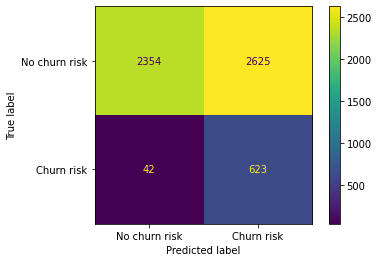

In [43]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label = ['No churn risk', 'Churn risk'] 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label)
disp.plot();

In [44]:
#Random forest nous donne l'importance des features qui ont été gardé pour le modèle. La somme de tous les scores des features gardées fait 1.
dict_feature = {}
for name, score in zip(best_search.named_steps["RF"].feature_names_in_, best_search.named_steps['RF'].feature_importances_):
    dict_feature[name]= score
pd.DataFrame.from_dict(dict_feature, orient='index').sort_values(by=0,ascending=False)

,0
num_tr__previous_session,0.180278
month_tr__month_cos,0.102039
num_tr__session_start_month,0.097148
num_tr__time_since_last_session_min,0.082202
num_tr__Time_Spent,0.069990
month_tr__month_sin,0.060979
num_tr__duration_min,0.050885
num_tr__game_events,0.044805
num_tr__week_maturity,0.040750
num_tr__event_type_Scene_Enter,0.031788


In [45]:
#Analyse de la variance des colonnes gardées
pd.DataFrame(best_search.named_steps["feat_selec"].scores_,index=best_search.named_steps["feat_selec"].feature_names_in_).sort_values(by=0,ascending=False)[:36]

,0
num_tr__previous_session,374.442558
month_tr__month_sin,228.165946
num_tr__session_start_month,213.422182
month_tr__month_cos,179.907367
num_tr__time_since_last_session_min,73.282819
num_tr__week_maturity,38.288887
num_tr__unique_activity,35.575090
num_tr__Time_Spent,34.263112
num_tr__game_events,26.929651
num_tr__event_type_Action_Click,26.056572


# Modèle uniquement sur les parents

In [46]:
#On réduit notre dataset aux sessions concernant uniquement les parents
parent_df = sm_df[sm_df['Type']=="Parent"]

In [47]:
#Nouveau jeu de donnée
X_parent = parent_df.drop('churn_risk',axis=1).copy()
y_parent = parent_df['churn_risk'].copy()

In [48]:
X_train_parent, X_test_parent, y_train_parent, y_test_parent = train_test_split(X_parent, y_parent, test_size=0.30)

In [49]:
#On refait un gridsearch sur ce jeu de donnée pour adapter les paramètres
grid_search.fit(X_train_parent, y_train_parent)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [68] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/antonin/.pyenv/versions/3.8.13/envs/marbotic/lib/python3.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        CustomColumnTransformer(transformers=[('num_tr',
                                                                               CustomMinMaxScale(),
                                                                               Index(['event_type_Account_Sign_In', 'event_type_Account_Sign_Out',
       'event_type_Account_Sign_Up', 'event_type_Account_Update_Request',
       'event_type_Account_Update_Success', 'event_type_Action_Click',
       'event_type_Action_ConversionClickRed...
                                                                               Cyclical_day_Encoder(),
                                                                               Index(['session_start_day'], dtype='object'))])),
                                       ('feat_selec',
                                        CustomSelectPercentile(percentile=50)),
                                       ('RF',
                                        BalancedRandomForestClassifier())]),
             param_grid={'RF__class_weight': ['balanced'],
                         'RF__max_depth': [60], 'RF__max_samples': [0.75],
                         'RF__min_samples_split': [20],
                         'RF__n_estimators': [60], 'RF__n_jobs': [-1]},
             scoring='recall', verbose=1)

In [50]:
#On selectionne le meilleur modèle
best_search_parent = grid_search.best_estimator_

In [51]:
y_pred_parent_stacked = best_search_parent.predict(X_test_parent)

In [52]:
#Evaluation
print(classification_report(y_test_parent,y_pred_parent_stacked,target_names=target_names))

              precision    recall  f1-score   support

    classe 0       0.98      0.46      0.62      4006
    Classe 1       0.20      0.94      0.32       567

    accuracy                           0.52      4573
   macro avg       0.59      0.70      0.47      4573
weighted avg       0.88      0.52      0.59      4573

